In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models


In [20]:
data = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [22]:
data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

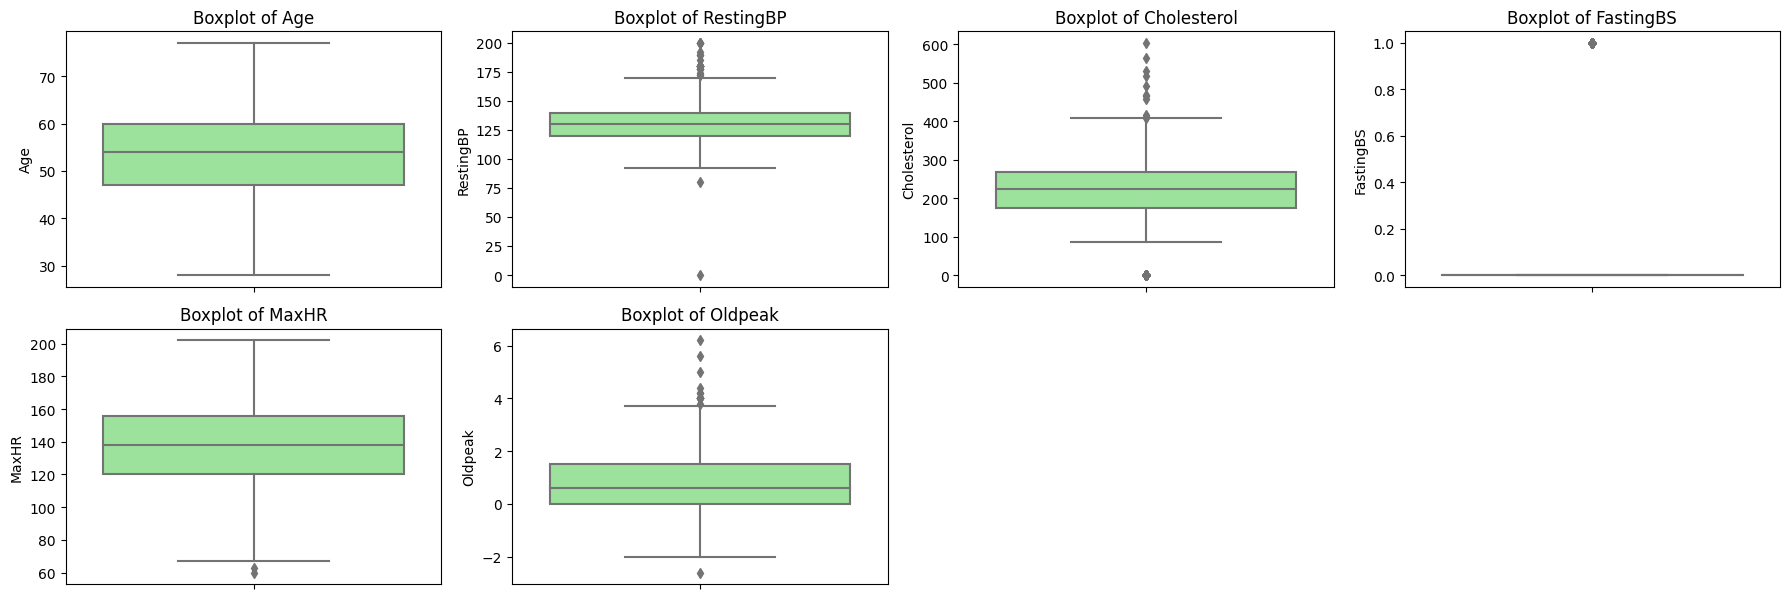

In [23]:
numeric_cols = data.drop("HeartDisease", axis=1).select_dtypes(include=["int64", "float64"]).columns
plt.figure(figsize = (18 , 12))
for i, column in enumerate(numeric_cols, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=data[column], color='lightgreen')
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()


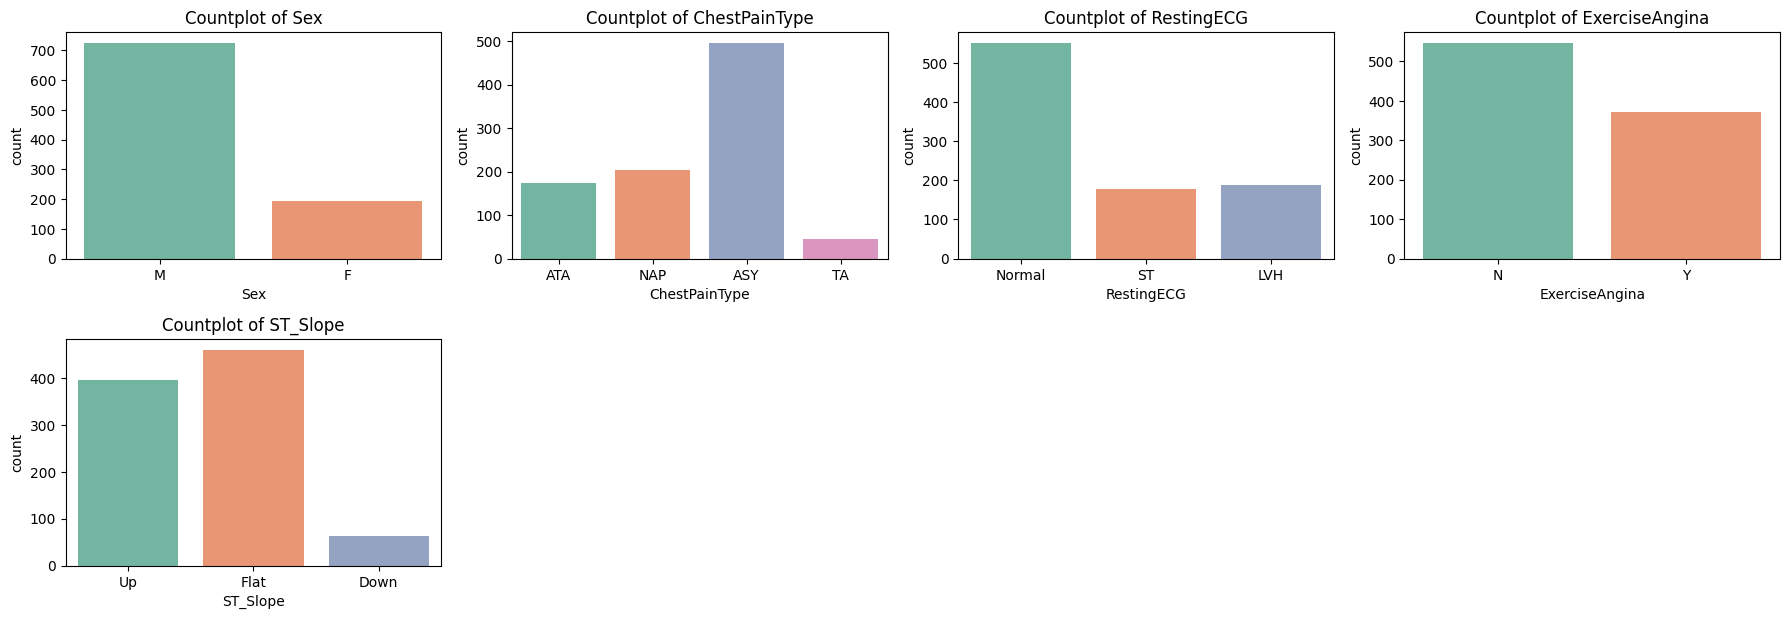

In [24]:
categorical_cols = data.drop("HeartDisease", axis=1).select_dtypes(include=["object", "bool"]).columns
plt.figure(figsize = (18 , 12))
for i, column in enumerate(categorical_cols, 1):
    plt.subplot(4, 4, i)
    sns.countplot(x=data[column], palette="Set2")
    plt.title(f'Countplot of {column}')

plt.tight_layout()
plt.show()


In [25]:
categorical_cols = data.select_dtypes(include=["object"]).columns
print("Categorical columns:", categorical_cols.tolist())
# Apply one-hot encoding to all categorical columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)


Categorical columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [26]:
data

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,True,False,False,True,True,False,False,True,False
914,68,144,193,1,141,3.4,1,True,False,False,False,True,False,False,True,False
915,57,130,131,0,115,1.2,1,True,False,False,False,True,False,True,True,False
916,57,130,236,0,174,0.0,1,False,True,False,False,False,False,False,True,False


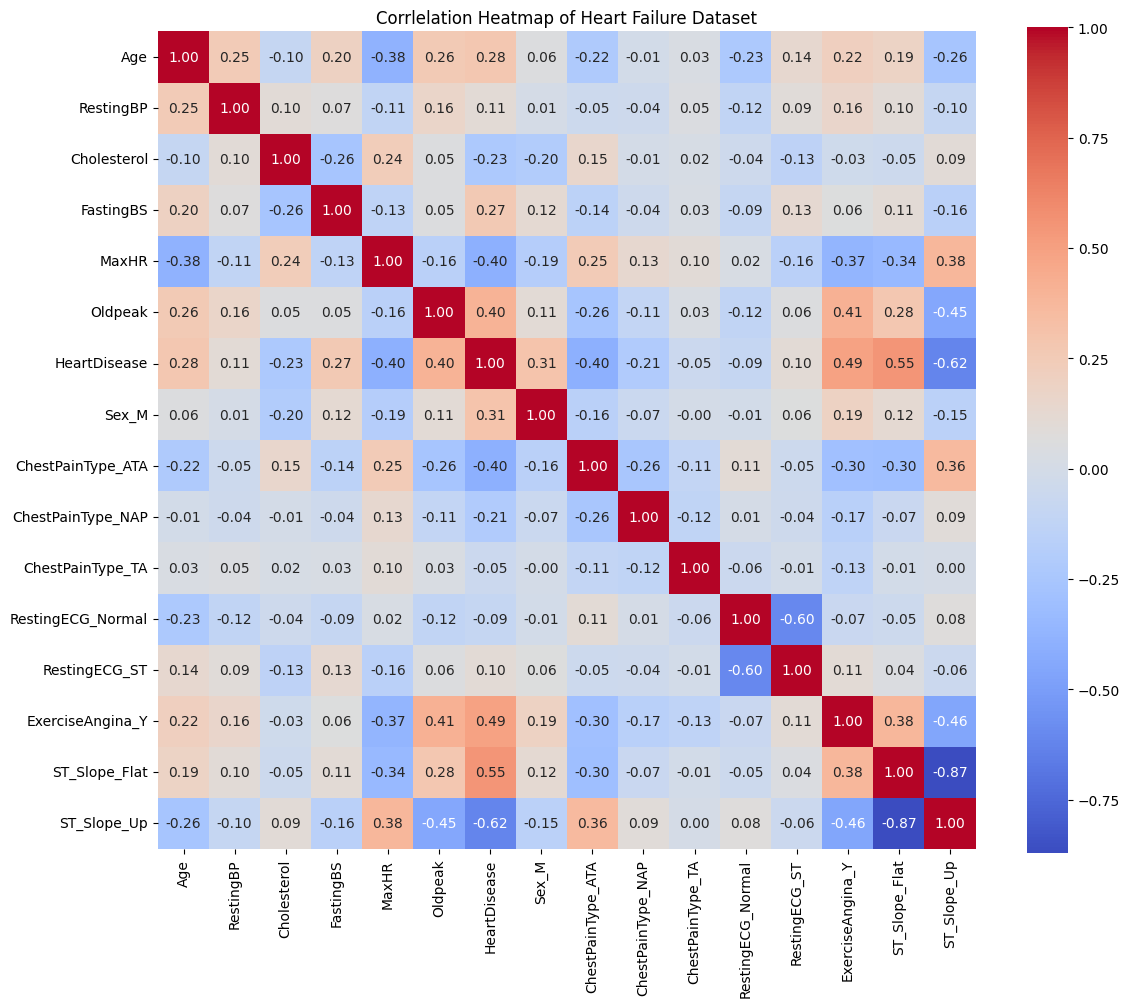

In [27]:
plt.figure(figsize = (12 , 10))
corr_matrix = data.corr()
sns.heatmap(corr_matrix,annot =True , fmt=".2f",cmap= "coolwarm",square=True , cbar=True)
plt.title("Corrlelation Heatmap of Heart Failure Dataset")
plt.tight_layout()
plt.show()

In [28]:
X = data.drop("HeartDisease", axis=1)  
y = data["HeartDisease"]

In [29]:
X = pd.get_dummies(X, drop_first=True)
X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,True,False,True,False,True,False,False,False,True


In [30]:
# Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
os.makedirs("model", exist_ok=True)
joblib.dump(scaler, 'model/scaler.pkl')
print("💾 Scaler saved as model/scaler.pkl")

💾 Scaler saved as model/scaler.pkl


In [34]:
# split Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [35]:
model = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")     
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=16, verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5925 - loss: 0.6712 - val_accuracy: 0.8095 - val_loss: 0.4873
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8312 - loss: 0.4360 - val_accuracy: 0.8095 - val_loss: 0.4309
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8710 - loss: 0.3401 - val_accuracy: 0.8163 - val_loss: 0.4310
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8819 - loss: 0.3134 - val_accuracy: 0.8367 - val_loss: 0.4415
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8721 - loss: 0.2921 - val_accuracy: 0.8367 - val_loss: 0.4429
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8619 - loss: 0.3235 - val_accuracy: 0.8367 - val_loss: 0.4446
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8781 - loss: 0.2969 - val_accuracy: 0.8231 - val_loss: 0.4475
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8693 - loss: 0.3324 - val_accuracy: 0.8299 - val_loss: 0.4446
Ep

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy: 0.8804347826086957
F1-score: 0.8921568627450981

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        82
           1       0.89      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



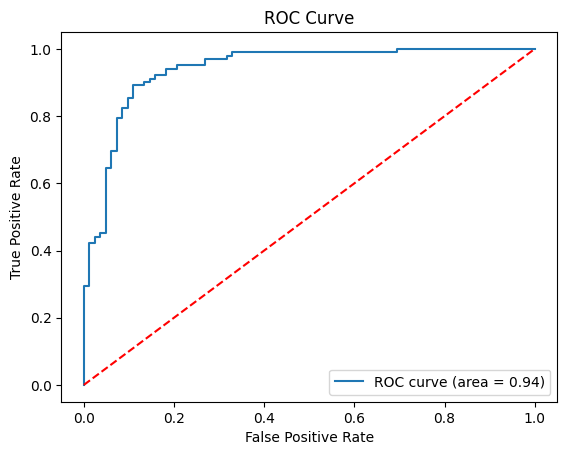

In [36]:
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %.2f)" % roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [37]:

model.save("heart_failure_ann.h5")

loaded_model = tf.keras.models.load_model("heart_failure_ann.h5")
